In [1]:
import numpy as np
import matplotlib.pyplot as plt

## XY Hamiltonian function setup
I will be using Kronecker products to implement direct products wherever required. Otherwise, I am using standard spinar states as spin basis states.

The Hamiltonian is as follows, for spin-1/2:

$$
\hat{H} = \sum_{n=0}^{N} \lambda(S_1^x S_2^x + S_1^y S_2^y)
$$

This may be written down as,

$$
\hat{H} = \sum_{n=0}^{N} \frac{\lambda}{2} ( S_1^{+} S_2^{-} + S_1^{-} S_2^{+} )
$$

Where $\S_i^{\pm}$ are Spin ladder operators. I use direct products to bring all operators to the dimensions of the system, which is $2^{N} \times 2^{N}$ for a system with $N$ particles. There is a boolean toggle in code that further creates a periodic condition where the last spin interacts with the first spin, thus making a ring. Numpy operations are avoided where possible, as efficiency of the code is not an issue for small N and I tried to implement all the required methods from scratch. If required, the `kp()` and `kp1()` functions may be replaced by the more efficient `np.kron()`, and more efficient and/or accurate ODE solvers than RK4 may be implement.

In [2]:
def kp(x,y):
    '''
    Generates the kronecker product of x and y
    x: numpy array
    y: numpy array
    '''
    m, n = x.shape
    p, q = y.shape

    result = np.zeros((m * p, n * q), dtype=np.result_type(x, y))

    for i in range(m):
        for j in range(n):
            result[i*p:(i+1)*p, j*q:(j+1)*q] = x[i, j] * y
    return result

def kp1(x,y):
    '''
    Kronecker product for row vectors
    '''
    m = x.shape[0]
    n = y.shape[0]

    result = np.zeros(m*n, dtype=np.result_type(x, y))

    for i in range(m):
        result[i*n:(i+1)*n] = x[i] * y
    return result

def identity(x=2,y=2):
    if x != y:
        print("Can not generate identity!")
        return np.ones((x,y))
    r = np.zeros((x,y))
    for i in range(x):
        r[i,i] = 1
    return r

def up(x,before,after):
    '''
    Upgrades x to 2*(before+after+1) dimensions
    by pre and post kronecker products with identity
    '''
    if before == 0 and after == 0:
        return x
    elif before == 0 and after != 0:
        r2 = identity()
        for i in range(after-1):
            r2 = kp(r2,identity())
        return kp(np.copy(x),r2)
    elif after == 0 and before != 0:
        r1 = identity()
        for i in range(before-1):
            r1 = kp(r1,identity())
        return kp(r1,np.copy(x))
    else:
        r1 = identity()
        r2 = identity()
        for i in range(before-1):
            r1 = kp(r1,identity())
        for i in range(after-1):
            r2 = kp(r2,identity())
        r = kp(r1,np.copy(x))
        r = kp(r,r2)
        return r

def genInitial(ini,N):
    #Prepare direct product initial state
    iniState = np.zeros(2**N)
    for i in range(N):
        if i == 0:
            if ini[0] == 1:
                c = np.array([1,0])
            else:
                c = np.array([0,1])
        else:
            if ini[i] == 1:
                cc = np.array([1,0])
            else:
                cc = np.array([0,1])
            c = kp1(c,cc)
    return c

def rk4ODE(f,ini,tf,t0=0,h=0.1):
    '''
    Simple RK4 ODE solver
    f: Update function
    ini: Initial State of the system
    tf: Final time
    t0: Initial time
    h: time step
    '''
    ret = [ini]
    t = t0
    times = [t0]
    while t < tf:
        k1 = f(ret[-1])
        k2 = f(ret[-1] + h/2 * k1)
        k3 = f(ret[-1] + h/2 * k2)
        k4 = f(ret[-1] + h * k3)
        ret.append(ret[-1] + (h/6) * (k1 + 2*k2 + 2*k3 + k4))
        t += h
        times.append(t)
    return ret, times

def XYHamiltonian(N,l,ini,upto,loop):
    '''
    Generates solutions to the XY Spin exchange Hamiltonian problem
    from t = 0 to t = upto
    N: Integer, Number of particles
    l: float, parameter
    upto: float
    loop: Boolean
    '''
    iniState = genInitial(ini,N)
    
    #Define the Hamiltonian matrix
    H = np.zeros((2**N,2**N)) #Two components for every added particle
    
    #Define the ladder operators
    Sp = np.zeros((2,2))
    Sp[0,1] = 1
    Sm = np.zeros((2,2))
    Sm[1,0] = 1
    
    #Prepare the Hamiltonian component by component
    #Leave out the boundaries as that will be set manually
    for n in range(N-1):
        #print(f"n: {n}")
        after = N-n-1
        before = n
        #print(f"before: {before}, after: {after}")
        c1 = up(np.copy(Sp),before,after)
        c3 = up(np.copy(Sm),before,after)
        c2 = up(np.copy(Sm),before+1,after-1)
        c4 = up(np.copy(Sp),before+1,after-1)
        #print(f"Shapes -> c1: {c1.shape}, c2: {c2.shape}, c3: {c3.shape}, c4: {c4.shape}")
        H += c1 @ c2 + c3 @ c4
    
    #Manually carrying out the last component - REMOVE if you do not want Nth particle to interact with 1st particle
    if loop:
        c1 = up(np.copy(Sp),N-1,0)
        c2 = up(np.copy(Sm),0,N-1)
        c3 = up(np.copy(Sp),0,N-1)
        c4 = up(np.copy(Sm),N-1,0)
        H += (c1 @ c2) + (c3 @ c4)
    
    H = (l/2)*H
    print("Hamiltonian Matrix: ")
    print(H)
    
    def update(state):
        return -1j*(H @ state.T)
    
    #print(update(iniState))
    
    #Solving using RK4
    sol, ts = rk4ODE(update,iniState,upto)

    return sol, ts

#Process and display

#Expectation operator
def expectation(operator,state):
    return np.real(np.conj(state.T) @ operator @ state)

## Using XYHamiltonian function

Hamiltonian Matrix: 
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
Hamiltonian Matrix: 
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]


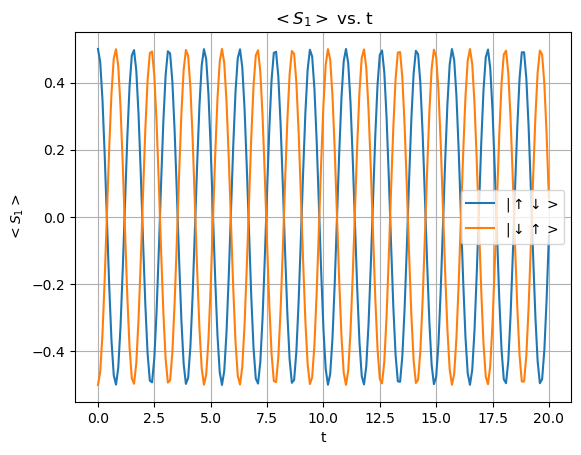

In [3]:
#Parameters
N = 2 #Number of particles
l = 2 #lambda parameter
ini = [1,0] #Initial state array - 1 for up, 0 for down - MUST BE OF LENGTH N
upto = 20 #Time upto which the simulation will run
loop = True #Do you want the last particle to interact with the first?

#Define Sz operator for spin 1
Sz = np.zeros((2,2))
Sz[0,0] = 1/2
Sz[1,1] = -1/2
Sz1 = up(Sz,0,N-1)

sol, ts = XYHamiltonian(N,l,ini,upto,loop)

szInst = [expectation(Sz1, state) for state in sol]

plt.plot(ts,szInst, label="$| \\uparrow \\downarrow >$")

ini = [0,1,]

#Solving using RK4
sol, ts = XYHamiltonian(N,l,ini,upto,loop)
szInst = [expectation(Sz1, state) for state in sol]

plt.plot(ts,szInst,label="$| \\downarrow \\uparrow >$")
plt.xlabel("t")
plt.ylabel("$< S_1 >$")
plt.title("$< S_1 >$ vs. t")
plt.legend()
plt.grid()
plt.show()

## Plotting the time average of the Instantaneous $< S_1^z >$ value

It is expected that the more the number of interacting spins, the faster the average goes to zero and the smaller the fluctuations.

In [6]:
Ns = [2,4,8,10]
Sz1Avg = dict() #Dictionary will hold the N indexed data list for average magnetization of the first spin
upto = 50
loop = False
l = 1 #Positive lambda

for i in Ns:
    #Create the Sz1 operator for this space
    Sz = np.zeros((2,2))
    Sz[0,0] = 1/2
    Sz[1,1] = -1/2
    Sz1 = up(Sz,0,i-1)
    #Creating two initial states, opposites of each other with the same nummber of ups and downs
    ini1 = [j%2 for j in range(i)]
    ini2 = [(j+1)%2 for j in range(i)]
    sol1, ts = XYHamiltonian(i,l,ini1,upto,loop)
    sol2, ts = XYHamiltonian(i,l,ini2,upto,loop)
    szinst1 = [expectation(Sz1,state) for state in sol1]
    szinst2 = [expectation(Sz1,state) for state in sol2]
    avg1 = []
    avg2 = []
    c1 = 0
    c2 = 0
    for j in range(len(szinst1)):
        c1 += szinst1[j]
        c2 += szinst2[j]
        avg1.append(c1/(j+1))
        avg2.append(c2/(j+1))
    Sz1Avg[i] = [list(avg1),list(avg2)]

Hamiltonian Matrix: 
[[0.  0.  0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.  0. ]]
Hamiltonian Matrix: 
[[0.  0.  0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.  0. ]]
Hamiltonian Matrix: 
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.5 0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.5 0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  

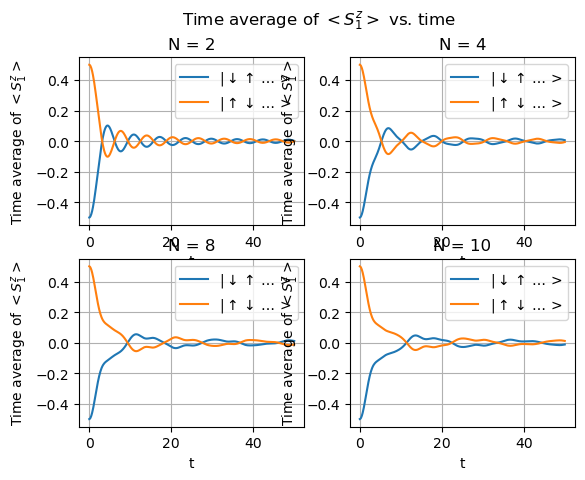

In [7]:
#Plotting
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.plot(ts,Sz1Avg[Ns[2*i+j]][0],label="$| \\downarrow \\uparrow \\dots >$")
        plt.plot(ts,Sz1Avg[Ns[2*i+j]][1],label="$| \\uparrow \\downarrow \\dots >$")
        plt.xlabel("t")
        plt.ylabel("Time average of $< S_1^z >$")
        plt.title(f"N = {Ns[2*i+j]}")
        plt.grid()
        plt.legend()

plt.suptitle("Time average of $< S_1^z >$ vs. time")
plt.show()

- Diptanuj Sarkar (ds22ms038@iiserkol.ac.in)
- 05-07-2025